In [2]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from spectral import open_image, envi

# spatial
import xarray as xa
import rasterio
import pyproj

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting

In [3]:
corr_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img"
corr_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img.hdr"
mask_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img"
mask_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img.hdr"

hs_mask_metadata = open_image(mask_fp_hdr)
hs_corrected_metadata = open_image(corr_fp_hdr)
print("masked:", hs_mask_metadata)
print("corrected:", hs_corrected_metadata)
hs_corrected_data = open_image(corr_fp_hdr).load()

masked: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_mask_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:             1
	Interleave:        BSQ
	Quantization:   8 bits
	Data format:     uint8
corrected: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_corr_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:           246
	Interleave:        BSQ
	Quantization:  32 bits
	Data format:   float32


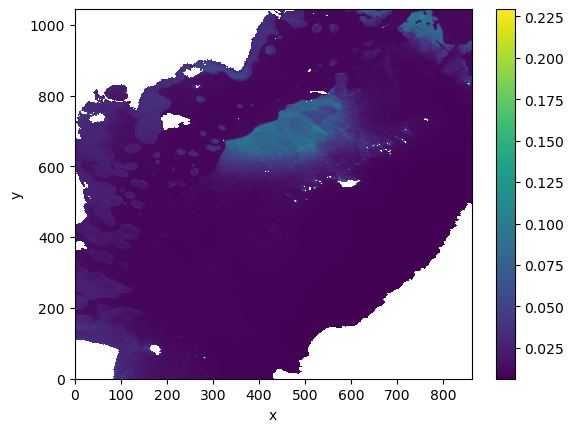

In [4]:
from pyproj import Transformer

def envi_to_xarray_with_latlon(envi_fp):
    # Open the ENVI file using rasterio
    with rasterio.open(envi_fp) as src:
        # Read the raster data into a numpy array
        data = src.read()

        # Get the affine transformation matrix from the ENVI metadata
        transform = src.transform

        # Get the dimensions of the image (height, width)
        height, width = src.shape

        # Generate UTM coordinates from pixel indices using the affine transform
        x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
        x_coords, y_coords = rasterio.transform.xy(transform, y_coords, x_coords)

        # Convert the UTM coordinates to numpy arrays
        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)

        # Convert UTM to lat/lon using pyproj or rasterio's CRS info
        transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
        lon_coords, lat_coords = transformer.transform(x_coords, y_coords)

        # Reshape lat and lon arrays to match the image dimensions
        lat_coords = np.reshape(lat_coords, (height, width))
        lon_coords = np.reshape(lon_coords, (height, width))

        # Create the xarray Dataset with lat/lon as coordinates
        dataset = xa.DataArray(
            data=data,  # The raster data
            dims=("band", "y", "x"),  # Dimensions of the data (e.g., bands, rows, cols)
            coords={
                "lat": (["y", "x"], lat_coords),  # Latitude coordinates (reshaped)
                "lon": (["y", "x"], lon_coords),  # Longitude coordinates (reshaped)
                "band": np.arange(1, data.shape[0] + 1),  # Band indices
            },
            attrs=src.meta  # Include the ENVI metadata
        )
        
    return dataset


spatial_xy_xa = envi_to_xarray_with_latlon(corr_fp)
mask_xa = envi_to_xarray_with_latlon(mask_fp)
# broadcast mask_xa to have same number of bands as scene_xa
mask_xa = mask_xa.broadcast_like(spatial_xy_xa)
mask_xa.values = np.broadcast_to(mask_xa.values[0], mask_xa.shape)
masked_scene_xa = spatial_xy_xa.where(mask_xa == 1, np.nan)

# # visualise data
mean_scene_xa = masked_scene_xa.median(dim="band", skipna=True)
mean_scene_xa.plot.imshow();

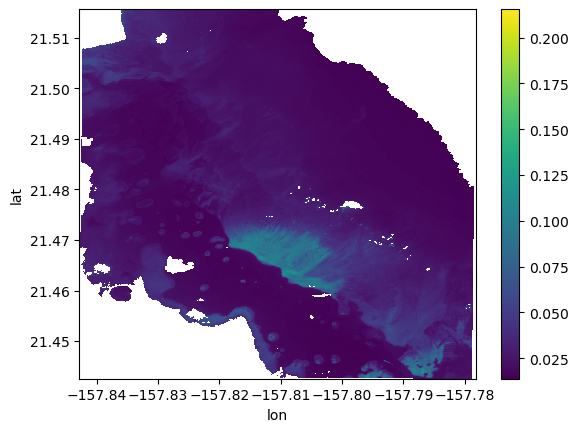

In [5]:
import rioxarray
import xesmf as xe


def regrid_with_xesmf(ds: xa.Dataset | xa.DataArray) -> xa.Dataset:
    # ds = ds.rio.reproject("EPSG:4326")
    lat_new = np.linspace(ds.lat.min(), ds.lat.max(), ds.sizes['y'])
    lon_new = np.linspace(ds.lon.min(), ds.lon.max(), ds.sizes['x'])

    target_grid = xa.Dataset({
        'lat': (['lat'], lat_new),
        'lon': (['lon'], lon_new)
    })

    regridder = xe.Regridder(ds, target_grid, 'bilinear', unmapped_to_nan=True)
    regridded_data = regridder(ds)
    regridded_data = regridded_data.where(regridded_data != 0, np.nan)
    regridded_data.attrs = ds.attrs
    # regridded_data.rio.crs = ds.crs
    return regridded_data


scene_xa = regrid_with_xesmf(masked_scene_xa)
scene_xa.mean(dim="band", skipna=True).plot.imshow()

In [6]:
masked_scene_vals = scene_xa.values.reshape(masked_scene_xa.shape[0], -1)

wvs = hs_corrected_metadata.bands.centers
hs_vals = pd.DataFrame(masked_scene_vals.T, columns=wvs)
# process: deglint and crop to sensor range
hs_vals = spectrum_utils.deglint_spectra(hs_vals)
hs_vals = spectrum_utils.crop_spectra_to_range(hs_vals)

hs_vals.head()

,452.642761,455.475067,458.307404,461.139801,463.972229,466.804749,469.637299,472.469940,475.302612,478.135345,...,662.383484,665.219910,668.056458,670.893005,673.729614,676.566284,679.403015,682.239807,685.076599,687.913513
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


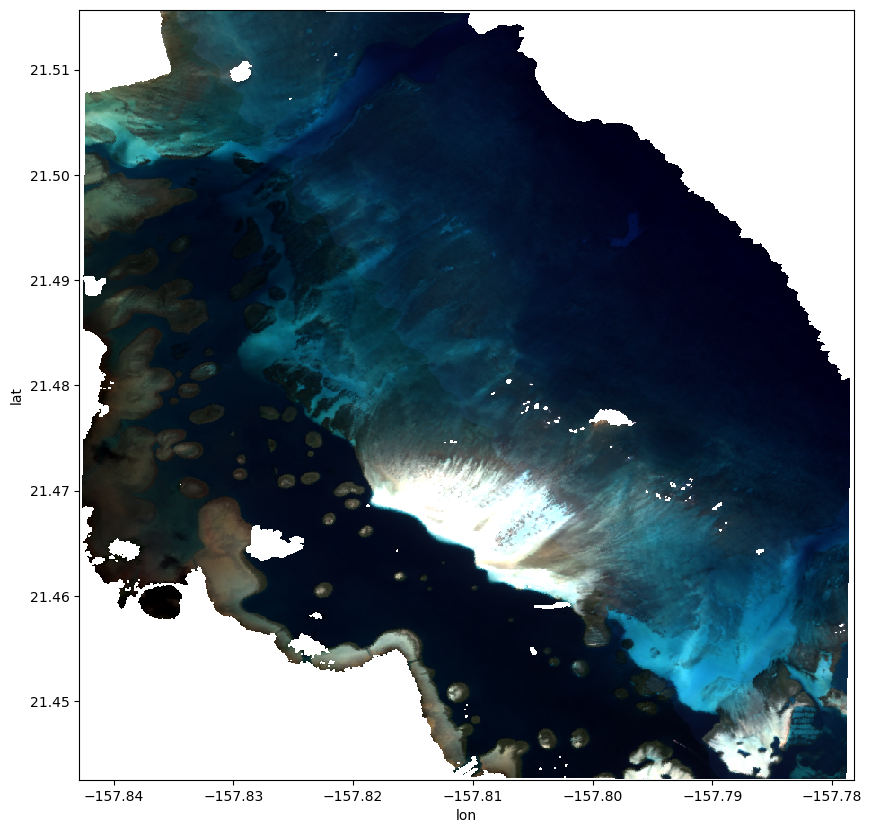

In [7]:
# plot, taking band values as RGB values
vis_percentiles=(0.1, 99.9)
rgb_vals = plotting.generate_spectra_color(hs_vals, vis_percentiles=vis_percentiles)

# reform rgb_vals back to masked_scene_xa dataset
rgb_xa = xa.DataArray(rgb_vals.reshape(len(scene_xa.lat), len(scene_xa.lon), -1), dims=("lat", "lon", "rgb"), coords={"lat": scene_xa.lat, "lon": scene_xa.lon, "rgb": ["r", "g", "b"]})
rgb_xa.plot.imshow(rgb="rgb", figsize=(10, 10), robust=True);

# ML

In [169]:
# load model
import joblib

model_fp = file_ops.RESOURCES_DIR_FP / "models" / "20241001-151758" / "best_rf.pkl"
rf_model = joblib.load(model_fp)

# remove nans
no_nan_hs_vals = hs_vals.dropna()
no_nan_hs_vals

,452.642761,455.475067,458.307404,461.139801,463.972229,466.804749,469.637299,472.469940,475.302612,478.135345,...,662.383484,665.219910,668.056458,670.893005,673.729614,676.566284,679.403015,682.239807,685.076599,687.913513
1589,0.036423,0.036779,0.036540,0.037009,0.037481,0.037539,0.037369,0.038489,0.038304,0.038910,...,0.005424,0.005417,0.005132,0.005158,0.004757,0.004683,0.004886,0.004673,0.004631,0.005459
1590,0.036728,0.036654,0.036743,0.037285,0.037512,0.037587,0.037695,0.038456,0.038200,0.038841,...,0.005484,0.005244,0.005063,0.005048,0.004723,0.004575,0.004799,0.004647,0.004629,0.005392
1591,0.036219,0.036805,0.036854,0.037274,0.037373,0.037578,0.037830,0.038174,0.038381,0.038483,...,0.005432,0.005596,0.005361,0.005344,0.004737,0.004879,0.004963,0.004850,0.004954,0.005631
1592,0.036541,0.036994,0.036965,0.037384,0.037599,0.038089,0.038348,0.038751,0.038754,0.038988,...,0.005760,0.005714,0.005354,0.005270,0.004945,0.005119,0.005126,0.005089,0.005031,0.005589
1593,0.036193,0.036120,0.037088,0.037088,0.037349,0.037478,0.037751,0.038484,0.038759,0.038670,...,0.005744,0.005681,0.005375,0.005198,0.004896,0.004948,0.005075,0.005137,0.004993,0.005636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900246,0.054861,0.055799,0.056879,0.057760,0.058791,0.059884,0.060103,0.061665,0.062393,0.063122,...,0.022769,0.021812,0.020958,0.020254,0.019765,0.019249,0.019109,0.018894,0.018868,0.019058
900247,0.054427,0.055557,0.056270,0.057821,0.058184,0.059657,0.060082,0.061243,0.062019,0.062890,...,0.023085,0.022157,0.021043,0.020466,0.019976,0.019469,0.019376,0.019304,0.019308,0.019418
900248,0.054419,0.055319,0.056005,0.057707,0.058154,0.059378,0.060048,0.060979,0.061629,0.062684,...,0.023267,0.022348,0.021050,0.020579,0.019835,0.019615,0.019333,0.019407,0.019458,0.019660
900249,0.055540,0.056483,0.057312,0.058556,0.059186,0.060057,0.060903,0.062016,0.062476,0.063731,...,0.023685,0.022460,0.021294,0.020711,0.020156,0.019963,0.019663,0.019609,0.019436,0.019753


In [171]:
# scale data and predict
scaler = MinMaxScaler()
scaler = scaler.fit(no_nan_hs_vals)
no_nan_hs_vals_scaled = scaler.transform(no_nan_hs_vals)

predicted_classes = rf_model.predict(no_nan_hs_vals_scaled)

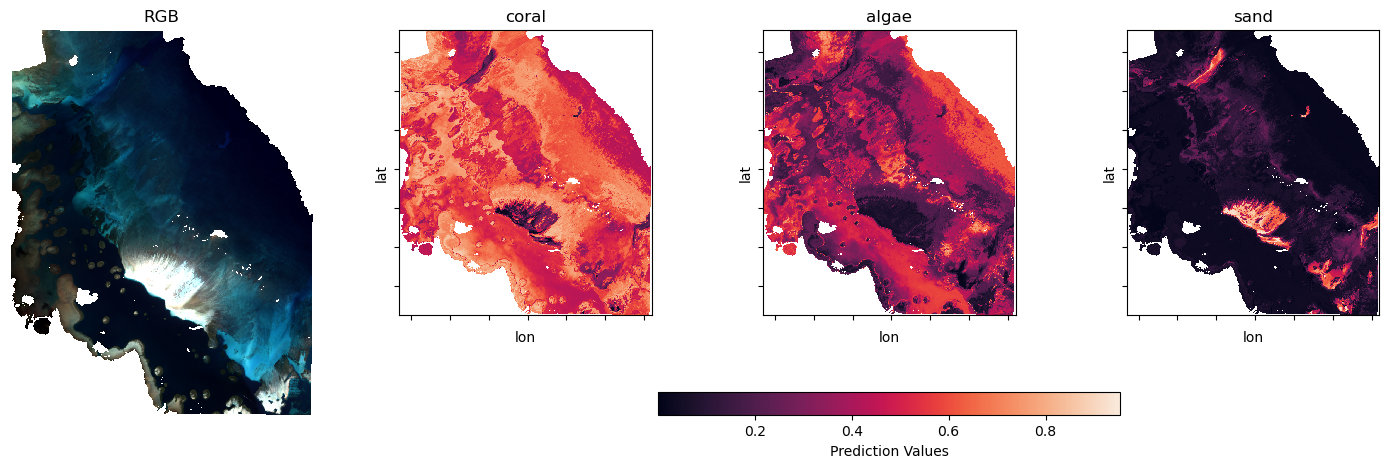

In [172]:
# visualise
predictions = pd.DataFrame(predicted_classes, columns=["coral", "algae", "sand"], index=no_nan_hs_vals.index)
# add in missing rows
full_index = pd.RangeIndex(start=hs_vals.index.min(), stop=hs_vals.index.max() + 1)
# Reindex the DataFrame to include missing indices and fill with NaN
filled_prediction_vals = predictions.reindex(full_index)
prediction_array = filled_prediction_vals.values.reshape(scene_xa.shape[1], scene_xa.shape[2], 3)

# create prediction array like scene_xa
prediction_xa = xa.Dataset(
    {
        "coral": (["lat", "lon"], prediction_array[:, :, 0]),
        "algae": (["lat", "lon"], prediction_array[:, :, 1]),
        "sand": (["lat", "lon"], prediction_array[:, :, 2]),
    },
    coords={"lat": scene_xa.lat, "lon": scene_xa.lon}
)

cmap = sns.color_palette("rocket", as_cmap=True)

fig, ax = plt.subplots(1, 4, figsize=(18, 5), sharex=True, sharey=True)

# Plot the RGB values on the first subplot
ax_rgb = ax[0]
rgb_xa.plot.imshow(rgb="rgb", ax=ax_rgb, robust=True)
ax_rgb.set_title('RGB')
ax_rgb.axis('off')


# Plot the prediction values on the remaining subplots
for i, var in enumerate(["coral", "algae", "sand"]):
    im = prediction_xa[var].plot.imshow(ax=ax[i+1], cmap="rocket", add_colorbar=False, vmin=predictions.min().min(), vmax=predictions.max().max())
    ax[i+1].set_title(var)
    # ax[i+1].invert_yaxis()
    # ax[i+1].axis('off')
    ax[i+1].set_xticklabels([])
    ax[i+1].set_aspect('equal')

# Add a single colorbar for all subplots except the RGB plot
cbar = fig.colorbar(im, ax=ax[1:], orientation='horizontal', fraction=0.06, pad=0.2)
cbar.set_label('Prediction Values')

In [173]:
from reflectance import ml_utils
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
print("validation sites:", validation_data.Locale.unique())
(X_train, X_test), (y1,y2), labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="prism_fits").generate_data()
labels = labels[~labels.index.duplicated(keep='first')]
kbay_indices = validation_data[validation_data.Locale == "Kaneohe Bay"].index



validation sites: ['Lizard Island' 'Heron Island' 'Lanai' 'Maui' 'Hawaii' 'Kaneohe Bay'
 'Palau']


In [174]:
# get indices of validation data in Kaneohe Bay
kbay_validation = validation_data.iloc[kbay_indices]
# join labels to validation data
kbay_labels = labels.loc[kbay_indices]
kbay_validation = kbay_validation.join(kbay_labels)

extent = (kbay_validation.X >= rgb_xa.lon.values.min()) & (kbay_validation.X <= rgb_xa.lon.values.max()) & (kbay_validation.Y >= rgb_xa.lat.values.min()) & (kbay_validation.Y <= rgb_xa.lat.values.max())
kbay_validation.loc[extent]

,X,Y,Campaign,Locale,Station,TimeUTC,TimeLocal,Depth,Metabolism,Optics,...,othUrchin,sedLimest,sedMud,sedRubble,sedSand,ROInumber,Flightline,algae,coral,sand
1151,-157.825553,21.471535,Hawaii,Kaneohe Bay,609,2/15/17 19:45,2/15/17 8:45,5.5,NaN,NaN,...,0,0,0,0,4,199,prm20170306t194614_corr_v1w3_img,56,39.0,4
1152,-157.825553,21.471535,Hawaii,Kaneohe Bay,609,2/15/17 19:45,2/15/17 8:45,5.5,NaN,NaN,...,0,0,0,0,4,199,prm20170306t194614_corr_v1w3_img,56,39.0,4
1153,-157.825553,21.471535,Hawaii,Kaneohe Bay,609,2/15/17 19:45,2/15/17 8:45,5.5,NaN,NaN,...,0,0,0,0,4,199,prm20170306t194614_corr_v1w3_img,56,39.0,4
1154,-157.825553,21.471535,Hawaii,Kaneohe Bay,609,2/15/17 19:45,2/15/17 8:45,5.5,NaN,NaN,...,0,0,0,0,4,199,prm20170306t194614_corr_v1w3_img,56,39.0,4
1155,-157.828916,21.492282,Hawaii,Kaneohe Bay,618,2/16/17 22:04,2/16/17 11:04,4.9,NaN,NaN,...,0,0,0,0,9,200,prm20170306t194614_corr_v1w3_img,34,45.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559,-157.815017,21.508195,Hawaii,Kaneohe Bay,619,2/16/17 23:44,2/16/17 12:44,4.3,NaN,NaN,...,0,0,0,0,3,287,prm20170306t202626_corr_v1w3_img,80,17.0,3
1560,-157.814883,21.507816,Hawaii,Kaneohe Bay,620,2/17/17 0:10,2/16/17 13:10,5.2,NaN,NaN,...,0,0,0,0,2,288,prm20170306t202626_corr_v1w3_img,72,26.0,2
1561,-157.814883,21.507816,Hawaii,Kaneohe Bay,620,2/17/17 0:10,2/16/17 13:10,5.2,NaN,NaN,...,0,0,0,0,2,288,prm20170306t202626_corr_v1w3_img,72,26.0,2
1562,-157.814883,21.507816,Hawaii,Kaneohe Bay,620,2/17/17 0:10,2/16/17 13:10,5.2,NaN,NaN,...,0,0,0,0,2,288,prm20170306t202626_corr_v1w3_img,72,26.0,2


In [177]:
kbay_X_train = X_train.loc[X_train.index.intersection(kbay_indices)].loc[extent]
kbay_X_train=kbay_X_train[~kbay_X_train.index.duplicated(keep='first')]
kbay_train_inds=kbay_X_train.index
kbay_X_test = X_test.loc[X_test.index.intersection(kbay_indices)].loc[extent]
kbay_X_test=kbay_X_test[~kbay_X_test.index.duplicated(keep='first')]
kbay_test_inds=kbay_X_test.index

In [178]:
kbay_train_meta = kbay_validation.loc[kbay_train_inds]
kbay_test_meta = kbay_validation.loc[kbay_test_inds]

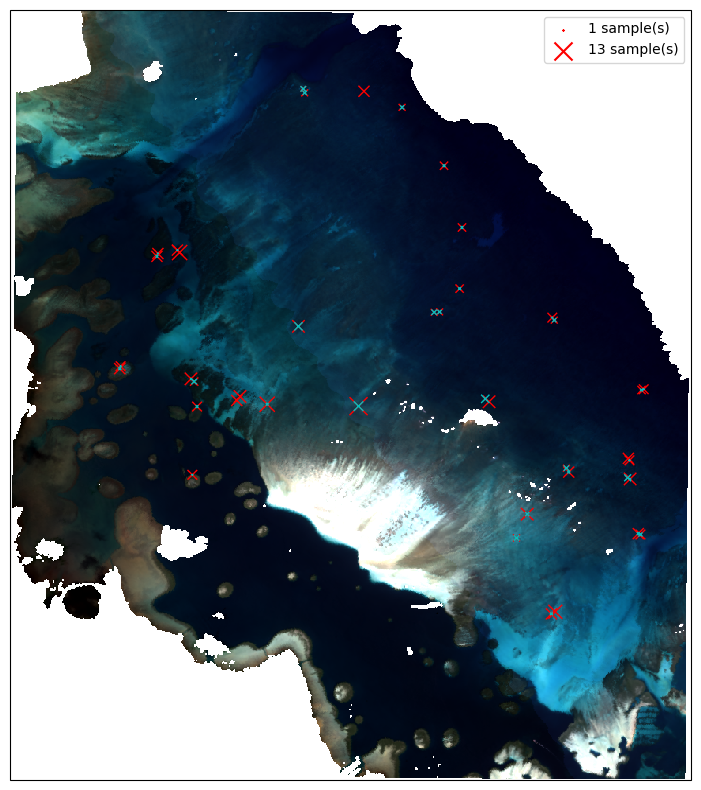

In [179]:
import cartopy.crs as ccrs

# join labels with validation data
kbay_validation_data = validation_data.iloc[kbay_indices].join(kbay_labels)
# select validation data within limits of rgb_xa
kbay_validation_data = kbay_validation_data[(kbay_validation_data.X >= rgb_xa.lon.values.min()) & (kbay_validation_data.X <= rgb_xa.lon.values.max()) & (kbay_validation_data.Y >= rgb_xa.lat.values.min()) & (kbay_validation_data.Y <= rgb_xa.lat.values.max())]

# count the number of samples at each site
train_sample_counts = kbay_train_meta.groupby(['X', 'Y']).size().reset_index(name='counts')
test_sample_counts = kbay_test_meta.groupby(['X', 'Y']).size().reset_index(name='counts')

# plot sites on the prediction map
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})
rgb_xa.plot.imshow(rgb="rgb", ax=ax, robust=True)
ax.scatter(train_sample_counts.X, train_sample_counts.Y, s=train_sample_counts.counts ** 2, color="red", marker="x", lw=1, alpha=1)
ax.scatter(test_sample_counts.X, test_sample_counts.Y, s=test_sample_counts.counts ** 2, color="c", marker="x", lw=1, alpha=1)
plt.scatter([],[], marker="x", s=min(min(train_sample_counts.counts), min(test_sample_counts.counts)) ** 2, color="red", label=f"{min(min(train_sample_counts.counts), min(test_sample_counts.counts))} sample(s)")
plt.scatter([],[], marker="x", s=max(max(train_sample_counts.counts), max(test_sample_counts.counts)) ** 2, color="red", label=f"{max(max(train_sample_counts.counts), max(test_sample_counts.counts))} sample(s)")
plt.legend()

In [180]:
# find the closest pixel to each site in kbay_validation_data
kbay_validation_data["lat"] = kbay_validation_data.Y
kbay_validation_data["lon"] = kbay_validation_data.X
kbay_validation_data["pixel_x"] = np.argmin(np.abs(rgb_xa.lon.values - kbay_validation_data.X.values[:, np.newaxis]), axis=1)
kbay_validation_data["pixel_y"] = np.argmin(np.abs(rgb_xa.lat.values - kbay_validation_data.Y.values[:, np.newaxis]), axis=1)
# determine index of prediction from closest pixel
kbay_validation_data["pixel_index"] = kbay_validation_data.pixel_y * rgb_xa.shape[1] + kbay_validation_data.pixel_x
kbay_validation_data["coral_pred"] = filled_prediction_vals.values[kbay_validation_data.pixel_index][:,0]
kbay_validation_data["algae_pred"] = filled_prediction_vals.values[kbay_validation_data.pixel_index][:,1]
kbay_validation_data["sand_pred"] = filled_prediction_vals.values[kbay_validation_data.pixel_index][:,2]
# add boolean column for train or test data
kbay_validation_data["train-test"] = kbay_validation_data.index.isin(kbay_train_inds)
kbay_validation_data

,X,Y,Campaign,Locale,Station,TimeUTC,TimeLocal,Depth,Metabolism,Optics,...,sand,lat,lon,pixel_x,pixel_y,pixel_index,coral_pred,algae_pred,sand_pred,train-test
1151,-157.825553,21.471535,Hawaii,Kaneohe Bay,609,2/15/17 19:45,2/15/17 8:45,5.5,NaN,NaN,...,4,21.471535,-157.825553,230,414,357512,0.555087,0.489687,0.013304,True
1152,-157.825553,21.471535,Hawaii,Kaneohe Bay,609,2/15/17 19:45,2/15/17 8:45,5.5,NaN,NaN,...,4,21.471535,-157.825553,230,414,357512,0.555087,0.489687,0.013304,True
1153,-157.825553,21.471535,Hawaii,Kaneohe Bay,609,2/15/17 19:45,2/15/17 8:45,5.5,NaN,NaN,...,4,21.471535,-157.825553,230,414,357512,0.555087,0.489687,0.013304,True
1154,-157.825553,21.471535,Hawaii,Kaneohe Bay,609,2/15/17 19:45,2/15/17 8:45,5.5,NaN,NaN,...,4,21.471535,-157.825553,230,414,357512,0.555087,0.489687,0.013304,True
1155,-157.828916,21.492282,Hawaii,Kaneohe Bay,618,2/16/17 22:04,2/16/17 11:04,4.9,NaN,NaN,...,9,21.492282,-157.828916,186,710,612916,0.601652,0.387513,0.039522,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559,-157.815017,21.508195,Hawaii,Kaneohe Bay,619,2/16/17 23:44,2/16/17 12:44,4.3,NaN,NaN,...,3,21.508195,-157.815017,371,937,809002,0.767174,0.156522,0.089348,False
1560,-157.814883,21.507816,Hawaii,Kaneohe Bay,620,2/17/17 0:10,2/16/17 13:10,5.2,NaN,NaN,...,2,21.507816,-157.814883,373,932,804689,0.762522,0.154348,0.094304,False
1561,-157.814883,21.507816,Hawaii,Kaneohe Bay,620,2/17/17 0:10,2/16/17 13:10,5.2,NaN,NaN,...,2,21.507816,-157.814883,373,932,804689,0.762522,0.154348,0.094304,False
1562,-157.814883,21.507816,Hawaii,Kaneohe Bay,620,2/17/17 0:10,2/16/17 13:10,5.2,NaN,NaN,...,2,21.507816,-157.814883,373,932,804689,0.762522,0.154348,0.094304,True


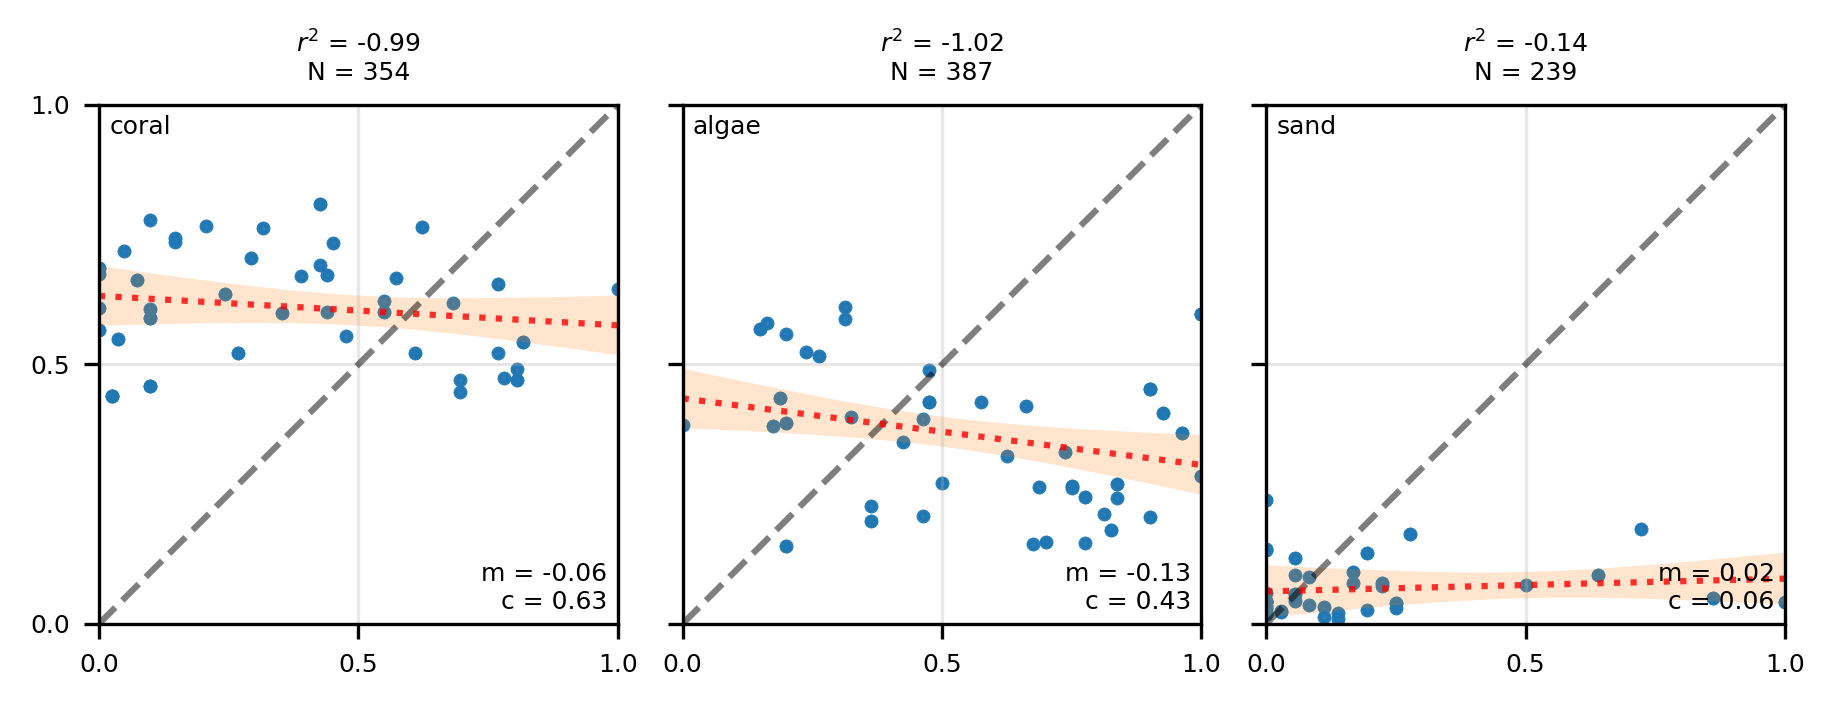

In [182]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(kbay_validation_data[["coral", "algae", "sand"]].loc[kbay_train_inds])  # scale on train data
# scale data by train scaler
test_data = pd.DataFrame(scaler.transform(kbay_validation_data[["coral", "algae", "sand"]]), index=kbay_validation_data.index, columns=["coral", "algae", "sand"])
pred_data = kbay_validation_data[["coral_pred", "algae_pred", "sand_pred"]].values
labels = test_data


plotting.plot_regression_results(test_data, pred_data, labels,
                                #  metadata=kbay_validation_data, color_by="Depth"
                                 )


In [183]:
# scale ["coral", "algae", "sand"] columns in kbay_validation_data
kbay_validation_data[["coral", "algae", "sand"]] = scaler.transform(kbay_validation_data[["coral", "algae", "sand"]])

train_results = kbay_validation_data[kbay_validation_data["train-test"] == True]
test_results = kbay_validation_data[kbay_validation_data["train-test"] == False]
train_results_true = train_results[["coral", "algae", "sand"]]
train_results_pred = train_results[["coral_pred", "algae_pred", "sand_pred"]]
test_results_true = test_results[["coral", "algae", "sand"]]
test_results_pred = test_results[["coral_pred", "algae_pred", "sand_pred"]]

-0.8308040811396425

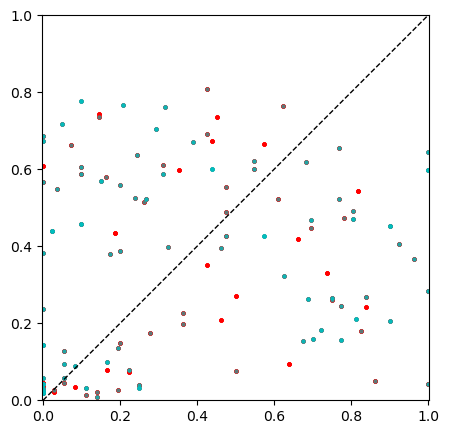

In [192]:
plt.figure(figsize=(5, 5))
plt.scatter(train_results_true, train_results_pred, color="r", label="Train Data", alpha=0.5, s=5)
plt.scatter(test_results_true, test_results_pred, color="c", label="Test Data", alpha=0.5, s=5)
plt.plot([0, 1], [0, 1], color="k", lw=1, ls="--")
plt.axis("equal")
plt.xlim(0, 1)
plt.ylim(0, 1)
from sklearn.metrics import r2_score
r2_score(test_results_true, test_results_pred)

,452.6427748,455.4750562,458.3073937,461.1397875,463.9722376,466.8047438,469.6373064,472.4699251,475.3026001,478.1353314,...,662.3834968,665.2199398,668.0564392,670.8929947,673.7296065,676.5662746,679.4029988,682.2397794,685.0766161,687.9135091
0,0.160828,0.162001,0.163048,0.164121,0.165242,0.166439,0.167707,0.168888,0.169837,0.170598,...,0.074032,0.071058,0.068560,0.066616,0.065337,0.064561,0.064084,0.063774,0.063667,0.063801
1,0.160381,0.161520,0.162533,0.163575,0.164667,0.165840,0.167091,0.168263,0.169213,0.169976,...,0.074246,0.071220,0.068684,0.066717,0.065430,0.064657,0.064201,0.063937,0.063906,0.064148
2,0.150419,0.151466,0.152392,0.153343,0.154343,0.155422,0.156578,0.157663,0.158538,0.159236,...,0.068821,0.065945,0.063536,0.061668,0.060444,0.059710,0.059281,0.059043,0.059036,0.059288
3,0.162043,0.163170,0.164175,0.165213,0.166306,0.167485,0.168747,0.169933,0.170897,0.171677,...,0.073637,0.070648,0.068148,0.066213,0.064948,0.064187,0.063732,0.063458,0.063409,0.063628
4,0.162576,0.163761,0.164819,0.165907,0.167049,0.168273,0.169577,0.170796,0.171789,0.172592,...,0.075902,0.072842,0.070276,0.068287,0.066987,0.066210,0.065752,0.065483,0.065446,0.065686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,0.072340,0.072732,0.073121,0.073650,0.074238,0.074813,0.075317,0.075561,0.075462,0.075246,...,0.009841,0.009613,0.009413,0.009238,0.009102,0.008978,0.008831,0.008634,0.008387,0.008100
1934,0.076645,0.077230,0.077799,0.078523,0.079324,0.080130,0.080880,0.081353,0.081440,0.081383,...,0.009699,0.009464,0.009259,0.009081,0.008944,0.008821,0.008675,0.008479,0.008233,0.007947
1935,0.086041,0.086853,0.087613,0.088545,0.089586,0.090684,0.091768,0.092575,0.092950,0.093132,...,0.009611,0.009324,0.009080,0.008874,0.008719,0.008584,0.008425,0.008211,0.007942,0.007629
1936,0.077959,0.078580,0.079165,0.079887,0.080680,0.081495,0.082289,0.082851,0.083050,0.083090,...,0.009609,0.009348,0.009126,0.008937,0.008793,0.008666,0.008520,0.008325,0.008083,0.007801


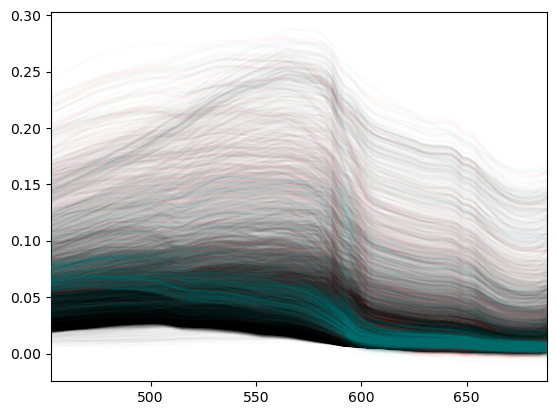

In [238]:
# compare spectra
prism_spectra = spectrum_utils.preprocess_prism_spectra(spectrum_utils.load_spectra())
fit_fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/results/fits/fit_results_1.csv"
fits = pd.read_csv(fit_fp, header=[0,1])
fits = fits.fitted_spectra
fits.columns = fits.columns.astype(float)

plt.plot(no_nan_hs_vals[::100].T, c="k", alpha=0.01);
plt.plot(prism_spectra.T, c="r", alpha=0.01);
plt.plot(fits.T, c="c", alpha=0.01, zorder=10);
plt.xlim(prism_spectra.columns.min(), prism_spectra.columns.max());

In [239]:
N = -1
spectra_source1 = no_nan_hs_vals.iloc[:N,:]
spectra_source2 = prism_spectra.iloc[:N,:]
spectra_source3 = fits.iloc[:N,:]
spectra_source2.shape[1]

84

In [240]:
# statistically compare two batches of spectra
from scipy.stats import ks_2samp

p_values = np.zeros(spectra_source1.shape[1])
for i in range(spectra_source1.shape[1]):
    stat, p_val = ks_2samp(spectra_source3.iloc[:, i], spectra_source2.iloc[:, i])
    p_values[i] = p_val
    
p_values

array([9.99999994e-01, 1.00000000e+00, 1.00000000e+00, 9.99950146e-01,
       1.00000000e+00, 9.99999926e-01, 9.10018309e-01, 8.91655558e-01,
       9.97034939e-01, 9.99999994e-01, 9.65244158e-01, 9.74370125e-01,
       9.26626950e-01, 9.99999411e-01, 1.00000000e+00, 9.99996662e-01,
       9.99950146e-01, 9.99999994e-01, 9.99197036e-01, 9.99996662e-01,
       9.87493385e-01, 6.99817690e-01, 8.50178092e-01, 9.87493385e-01,
       6.18677374e-01, 4.63108513e-01, 8.27374875e-01, 8.71659946e-01,
       9.41392815e-01, 9.99197036e-01, 9.99996662e-01, 9.99999994e-01,
       9.99999411e-01, 9.99950146e-01, 9.97034939e-01, 7.78516183e-01,
       9.41392815e-01, 9.99999994e-01, 1.00000000e+00, 9.94919931e-01,
       9.99855490e-01, 9.98389890e-01, 8.50178092e-01, 9.94919931e-01,
       9.99638092e-01, 9.87493385e-01, 9.81739160e-01, 8.03426817e-01,
       1.83655151e-01, 2.57209681e-01, 3.93197202e-01, 2.43370320e-03,
       8.12867044e-06, 2.22903770e-07, 7.09075388e-09, 2.91456585e-13,
      

In [241]:
# pca both distributions
from sklearn.decomposition import PCA

pca1 = PCA(n_components=1)
pca1.fit(spectra_source3)
pca_source1 = pca1.transform(spectra_source1)
pca2 = PCA(n_components=1)
pca2.fit(spectra_source2)
pca_source2 = pca2.transform(spectra_source2)

# statistically compare pca components
stat, p_val = ks_2samp(pca_source1, pca_source2)
print(stat, p_val)

[0.48761587] [0.]


In [242]:
ks_2samp(pca_source1, pca_source1)

KstestResult(statistic=array([0.]), pvalue=array([1.]), statistic_location=array([-0.66107043]), statistic_sign=array([1.]))

In [211]:
from statsmodels.multivariate.manova import MANOVA

# Combine data from both sources and add a label
data = np.vstack([spectra_source1.values, spectra_source2.values])
labels = np.array([0]*spectra_source1.shape[0] + [1]*spectra_source2.shape[0])

# Perform MANOVA (multivariate analysis of variance)
manova = MANOVA(endog=data, exog=labels)
print(manova.mv_test())


                     Multivariate linear model
                                                                   
-------------------------------------------------------------------
           x0           Value   Num DF    Den DF    F Value  Pr > F
-------------------------------------------------------------------
          Wilks' lambda 0.7498 84.0000 698926.0000 2776.7695 0.0000
         Pillai's trace 0.2502 84.0000 698926.0000 2776.7695 0.0000
 Hotelling-Lawley trace 0.3337 84.0000 698926.0000 2776.7695 0.0000
    Roy's greatest root 0.3337 84.0000 698926.0000 2776.7695 0.0000



- Predict depth and compare with LIDAR
- Use depth as a parameter